# Clarvoyant Constructor

I am a data scientist at a large construction company that wants to submit more competitive bids for contracts. My job is to forecast material costs for core construction materials.

### Available Data
10 years of past purchases of :
- plywood
- sheetrock (concrete in dataset)
- steel beams
- rebar
- glass 

### Key things to note
- Can purchase materials up to six months in advance
- Manager wants six months of forecasting
- When is a commodity price about to increase temporarily (hint autocorrelation)
    - When is a good time to buy that commodity?

----

### Forecasts:

In [1]:
import pandas as pd
forecast = pd.read_csv('data/construction_forecast.csv')
forecast = forecast.set_index('month')
forecast.columns = [c.replace('_interpolated', '') for c in forecast.columns.values]
forecast

,price_steel,price_plywood,price_rebar,price_concrete,price_glass
month,,,,,
2018-07-31,9.237355,15.051687,15.237896,37.086443,34.926585
2018-08-31,12.988838,12.024072,19.373775,34.236020,37.387673
2018-09-30,12.982009,11.276000,21.638790,36.461596,37.458806
2018-10-31,16.226631,15.062396,23.120512,36.009639,37.130170
2018-11-30,25.335775,11.606134,32.482120,37.419724,37.702288
2018-12-31,23.862303,12.319191,31.107044,39.123458,38.131123


### Best times to buy:
Steel: 
   - Lowest between May and August. 
   - Peaks in January.
   
Rebar: 
   - Lowest in August. 
   - Peaks in December.
   
Plywood: 
   - Lowest in May, October, and December. 
   - Peaks in March, August, and November.
   
Concrete: 
   - Lowest in September. 
   - Peaks in June.
   
Glass: 
   - Lowest in July and August. 
   - Peaks in May.
    

# Exploratory Data Analysis

In [2]:
import os
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
home_dir = os.getcwd()
data = pd.read_csv(os.path.join(home_dir, "data",  
       "construction_material_prices_2008_2018.csv"))

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945 entries, 0 to 2944
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      2945 non-null   object 
 1   price_steel     2309 non-null   float64
 2   price_rebar     1649 non-null   float64
 3   price_glass     1472 non-null   float64
 4   price_concrete  1447 non-null   float64
 5   price_plywood   2673 non-null   float64
dtypes: float64(5), object(1)
memory usage: 138.2+ KB


In [ ]:
display(HTML(data[:200].to_html()))

In [5]:
df = data.copy()
df.columns = ['purchase_date', 'price_steel', 'price_rebar', 
              'price_glass', 'price_concrete', 'price_plywood']
df.purchase_date = pd.to_datetime(df.purchase_date, 
             format = '%Y-%m-%d')
#df.head()
#df.info()

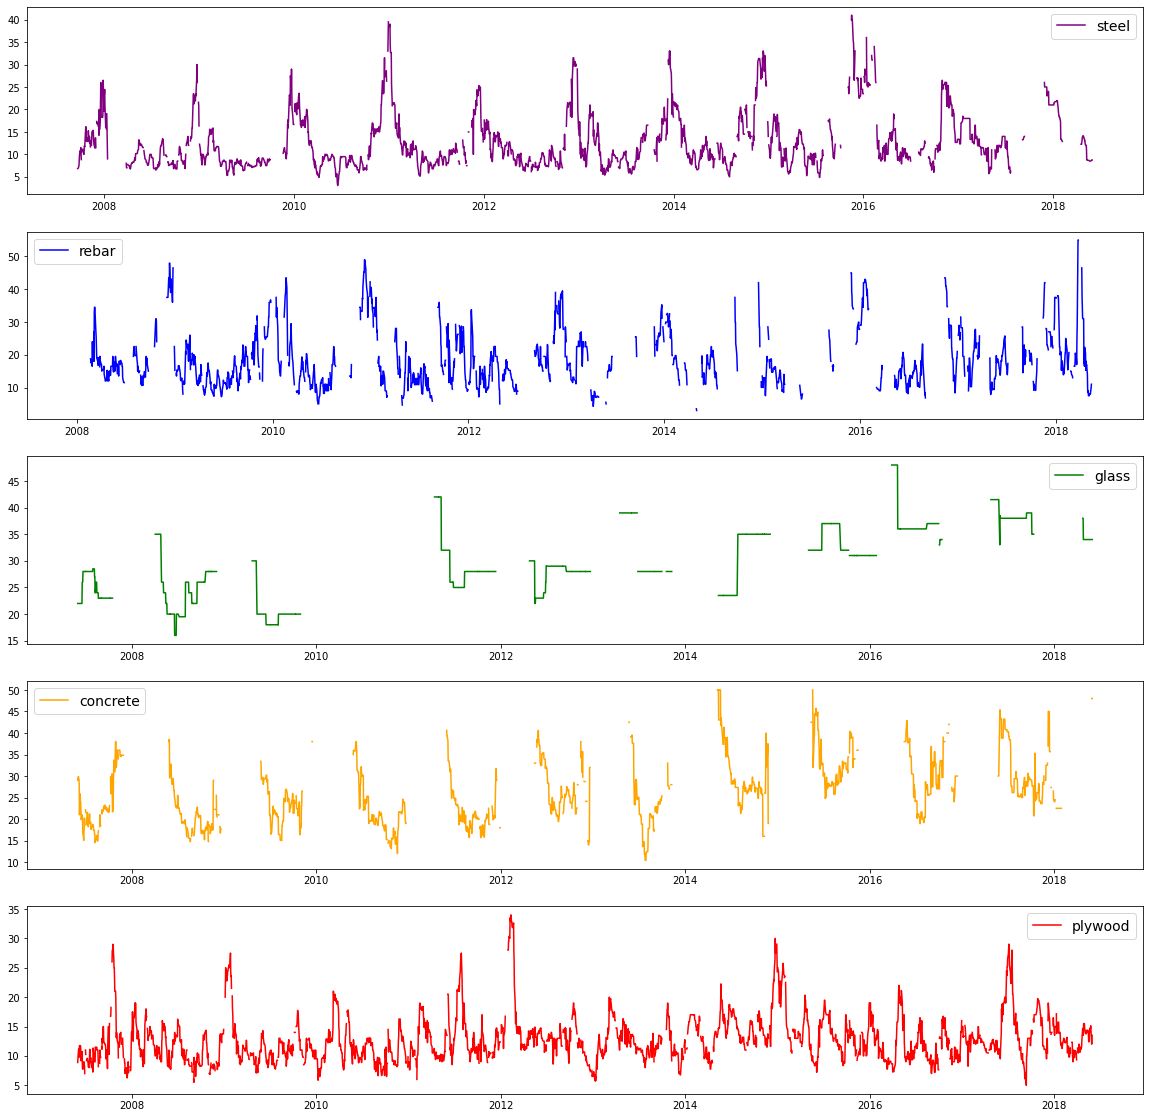

In [6]:
fig, ax = plt.subplots(5,1, figsize = (20,20))
ax[0].plot(df.purchase_date, df.price_steel, 
        color = 'purple', label = 'steel')
ax[1].plot(df.purchase_date, df.price_rebar, 
        color = 'blue', label = 'rebar')
ax[2].plot(df.purchase_date, df.price_glass, 
        color = 'green', label = 'glass')
ax[3].plot(df.purchase_date, df.price_concrete, 
        color = 'orange', label = 'concrete')
ax[4].plot(df.purchase_date, df.price_plywood, 
        color = 'red', label = 'plywood')
for a in ax:
    handles, labels = a.get_legend_handles_labels()
    a.legend(handles, labels, fontsize = 14)

#### Notes so far
- A lot of missing data
- Autocorrelation suspected in all traces
- Cross correlation in many cases

#### Implementation
- Dickey-Fuller
- Autoregression
- Moving Average
- S_G exponential smoothing
- After de-trending and removing autocorrelation, impute missing values 

---

# Missing data 
- intermittant -> steel and plywood
- chunks --> concrete, glass, rebar

#### Function definition to test imputation methods

In [7]:
df = df.set_index('purchase_date')

,price_steel_downsampled,price_steel_interpolated,price_rebar_downsampled,price_rebar_interpolated,price_glass_downsampled,price_glass_interpolated,price_concrete_downsampled,price_concrete_interpolated,price_plywood_downsampled,price_plywood_interpolated
purchase_date,,,,,,,,,,
2007-09-30,7.937500,7.937500,NaN,NaN,23.0,23.000000,22.216666,22.216666,11.695175,11.695175
2007-10-31,12.027462,12.027462,NaN,NaN,23.0,23.000000,27.847619,27.847619,20.714286,20.714286
2007-11-30,13.453333,13.453333,NaN,NaN,NaN,24.755495,34.868056,34.868056,12.362037,12.362037
2007-12-31,18.572368,18.572368,NaN,NaN,NaN,26.569505,NaN,35.085216,8.203704,8.203704
2008-01-31,17.361111,17.361111,21.0,21.0,NaN,28.383516,NaN,35.302376,15.261905,15.261905


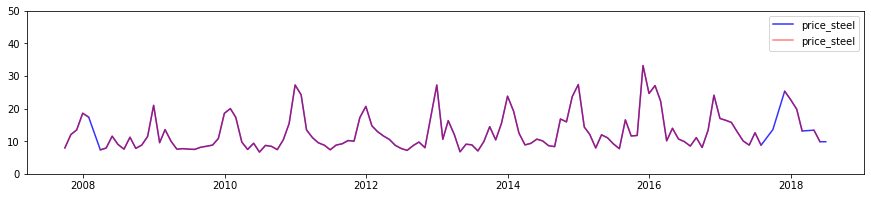

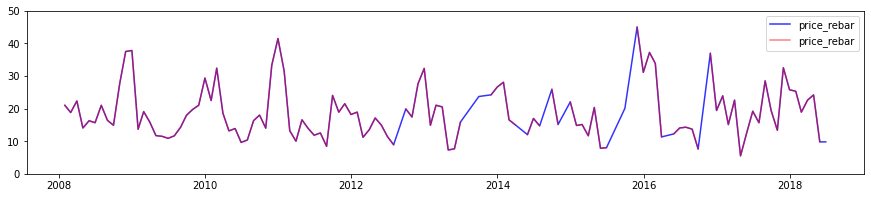

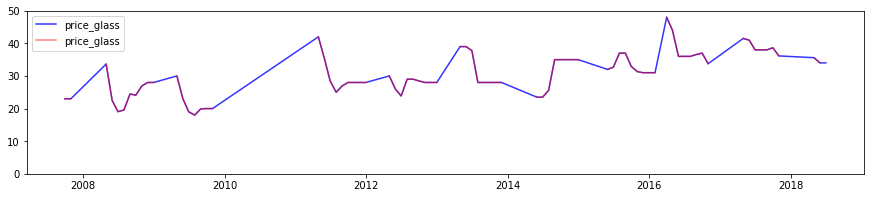

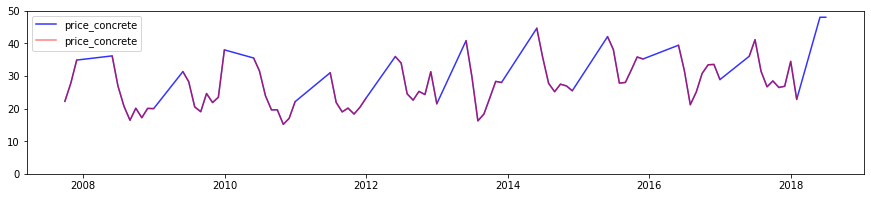

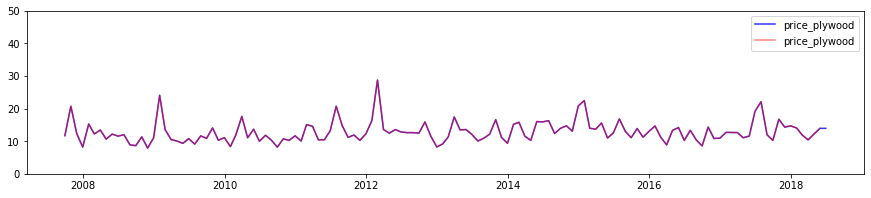

In [10]:
df = df.copy()
dfw = pd.DataFrame()


for c in df.columns.values:
    fig, ax  = plt.subplots(1,1, figsize = (15,3))
    
    # Trim starting NAs
    for i, v in enumerate(df[c]):
        if np.isnan(v) == False:
            df2 = df.iloc[i:,:]
            break
    resample = df2[c].resample('M')
    dfw[c + '_downsampled'] = resample.mean()
    dfw[c + '_interpolated'] = dfw[c + '_downsampled'].interpolate\
        (method='time')
    ax.plot(dfw.index, dfw[c + '_interpolated'], 
          label = c, color = 'blue', alpha = 0.8)
    ax.plot(dfw.index, dfw[c + '_downsampled'], label = c, 
            alpha = 0.5, color = 'red')
    ax.set_ylim(0,50)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles,labels)
dfw.head()


In [11]:
# List of downsampled, interpolated columns
ds_cols = ['price_steel_interpolated','price_plywood_interpolated',
              'price_rebar_interpolated','price_concrete_interpolated',
              'price_glass_interpolated']


---
### _Imputation_
_Interpolation using the "time" method, which assumes constant interevent intervals along the x-axis is best for imputing missing time series data. Downsampling to daily intervals provided the most informative interpolation for steel and glass, but these took forever to run through the ARIMA. For Plywood, rebar, and concrete, monthly downsampling was a better fit, so I compromised and interpolated by a month for all time series._ 

---

# Normality Tests

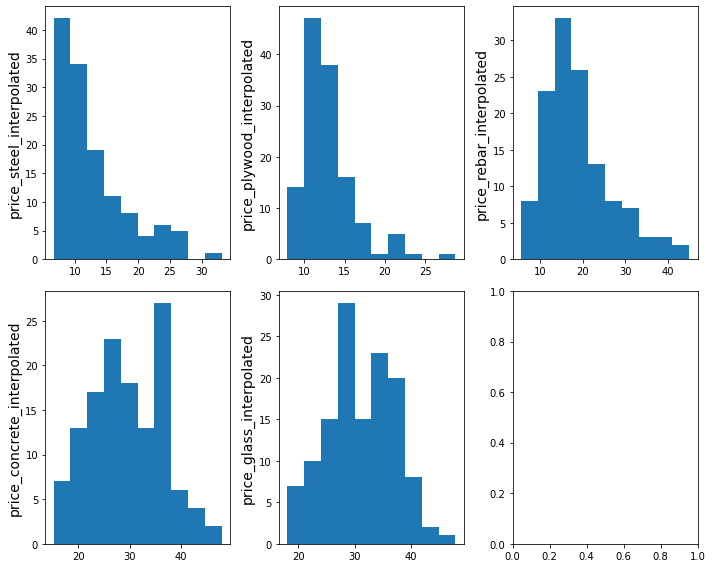

In [14]:
# Plot Histograms
i = 0
j = 0
fig, ax = plt.subplots(2,3, figsize = (10,8))
for c in ds_cols:
    ax[i][j].hist(dfw[c], stacked = False)
    ax[i][j].set_ylabel (c, fontsize = 14)
    if j ==2:
        i += 1
        j = -1
    j += 1 
plt.tight_layout()

# Shapiro-Wilk

In [15]:
from scipy.stats import shapiro

for c in ds_cols:
    stat, p = shapiro(dfw[c].dropna())
    print(c, end = ': ')
    print('Statistics = %.3f, p = %.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)\n')
    else:
        print('Sample does not look Gaussian (reject H0)\n')

price_steel_interpolated: Statistics = 0.850, p = 0.000
Sample does not look Gaussian (reject H0)

price_plywood_interpolated: Statistics = 0.873, p = 0.000
Sample does not look Gaussian (reject H0)

price_rebar_interpolated: Statistics = 0.933, p = 0.000
Sample does not look Gaussian (reject H0)

price_concrete_interpolated: Statistics = 0.983, p = 0.112
Sample looks Gaussian (fail to reject H0)

price_glass_interpolated: Statistics = 0.985, p = 0.157
Sample looks Gaussian (fail to reject H0)



# Dickey-Fuller 

In [16]:
from statsmodels.tsa.stattools import adfuller
for c in ds_cols:
    result = adfuller(dfw[c].dropna())
    print(c, end = ': ')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('\n')

price_steel_interpolated: ADF Statistic: -1.011900
p-value: 0.748899
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


price_plywood_interpolated: ADF Statistic: -8.504172
p-value: 0.000000
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579


price_rebar_interpolated: ADF Statistic: -7.379121
p-value: 0.000000
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580


price_concrete_interpolated: ADF Statistic: -1.929142
p-value: 0.318478
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


price_glass_interpolated: ADF Statistic: -3.032151
p-value: 0.031999
Critical Values:
	1%: -3.483
	5%: -2.885
	10%: -2.579




# Autocorrelation (p)

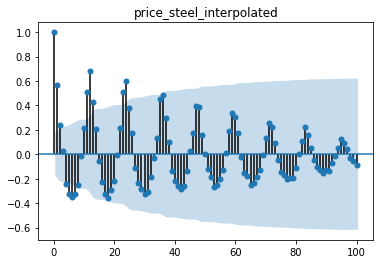

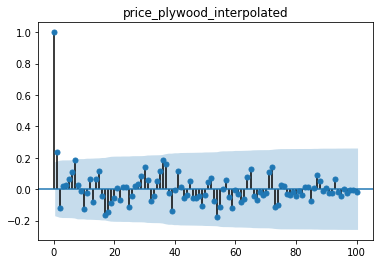

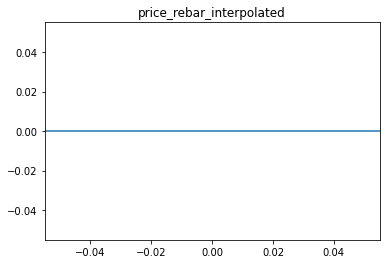

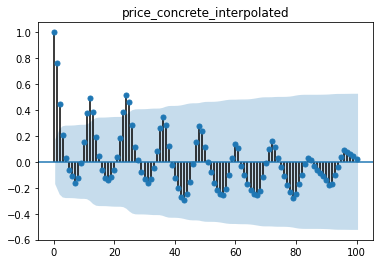

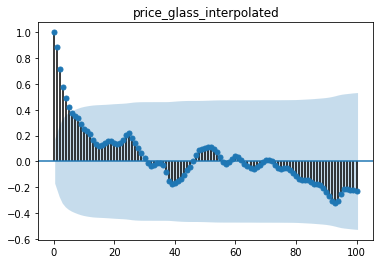

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

for c in ds_cols:
    plot_acf(dfw[c], lags = 100, title = c)

# Partial Autocorrelation (q)

/Users/haleyspeed/Docs/insight/ins_env/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


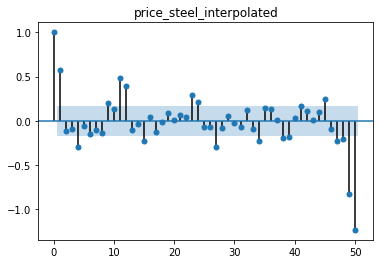

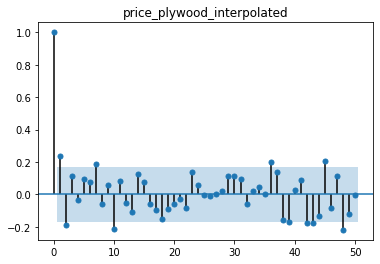

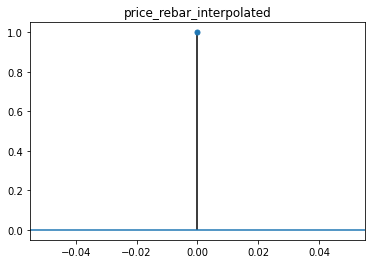

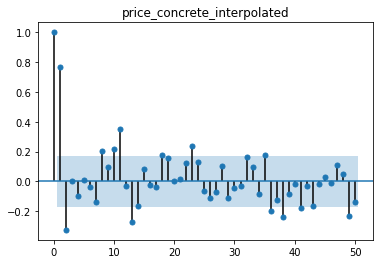

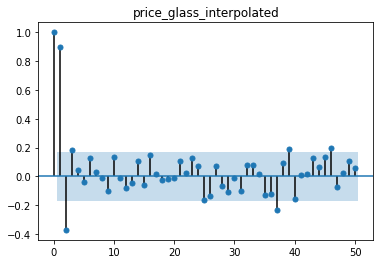

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf
for c in ds_cols:
    plot_pacf(dfw[c], lags=50, title = c)
plt.show()

### _Steel and Rebar are autocorrelated_
_Steel has a significant lag of 60 days (p = 60) and rebar has a lag of about 2 months (p = 2). The other time series lack autocorrelation and have normal distributions according to Shapiro-Wilk (p = 0). However, plywood shows a trend that must be taken into account, according to Dickey-Fuller (d = 1 or 2). q = 2 from the partial autocorrelation plot for both steel and rebar; p = 0 for everything else._

# Decomposition - Seasonality

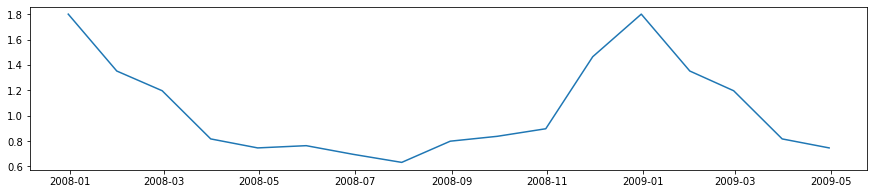

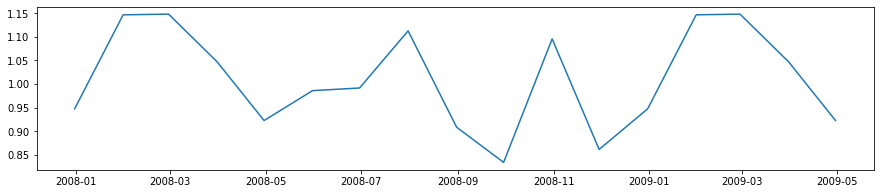

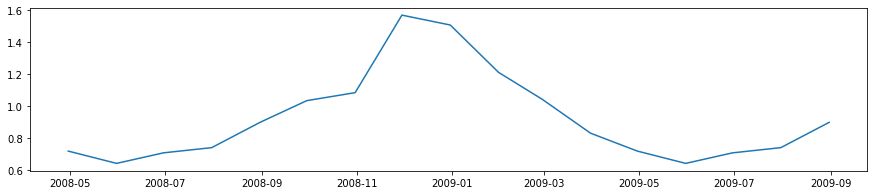

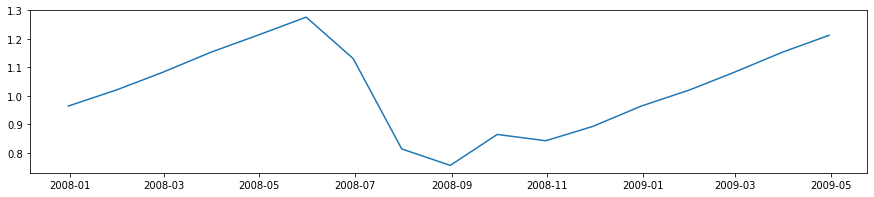

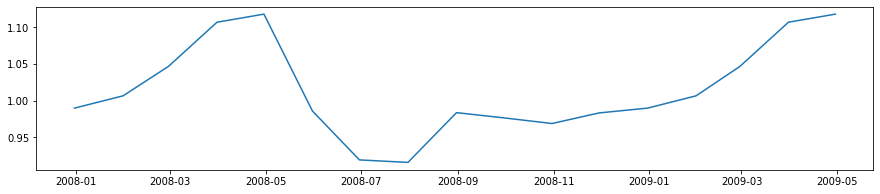

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy as sp

df_decomp = pd.DataFrame (columns = ds_cols)
for c in ds_cols:
    display(HTML('<h3><hr>'+ c + '</h3><hr>'))
    result = seasonal_decompose(dfw[c].dropna(), model='multiplicative')
    df_decomp[c] = result.seasonal
    
    # Fast Fourier Transform
    #season_fft = sp.fftpack.fft(result.seasonal.values)
    #season_psd = np.abs(season_fft) ** 2
    #fft_freq = sp.fftpack.fftfreq(len(season_psd), 12 / 365)
    #pos_freq = fft_freq > 0
    
    fig, ax = plt.subplots(1,1, figsize = (15,3)) 
    ax.plot(result.seasonal[3:20])
    #ax[1].plot(fft_freq[pos_freq], 10 * np.log10(season_psd[pos_freq]))
    
    #ax.set_xlim(0, 5)
    #ax[1].set_xlabel('Frequency (month/year)')
    #ax[1].set_ylabel('PSD (dB)')
    plt.show()
#display(HTML(df_decomp.to_html()))

# Make test and training sets

In [22]:
train_size = int(0.8 * dfw.price_steel_interpolated.shape[0])
test_size = int(0.2 * dfw.price_steel_interpolated.shape[0])
print(train_size, test_size)

104 26


# Trying ARIMA

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [24]:
model = ARIMA(dfw.price_steel_interpolated[:train_size].dropna(), order=(3,0,0))
model_fit = model.fit(disp=0)
#print(model_fit.summary())

In [ ]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

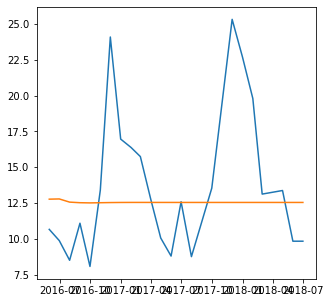

In [25]:
# Test predictions
predictions = model_fit.predict(start = dfw.price_steel_interpolated.index[train_size], 
                                end = dfw.price_steel_interpolated.index[test_size + train_size-1])
fig, ax = plt.subplots(1,1, figsize = (5,5))
ax.plot(dfw.price_steel_interpolated.index[train_size:], dfw.price_steel_interpolated[train_size:])
ax.plot(dfw.price_steel_interpolated.index[train_size:], predictions)

# Trying SARIMAX

In [26]:
from pmdarima.arima import auto_arima

In [40]:
#stepwise_model = auto_arima(dfw.price_steel_interpolated, start_p=1, start_q=1,
#                           max_p=3, max_q=3, m=12,
#                           start_P=0, seasonal=True,
#                           d=1, D=1, trace=True,
#                           error_action='ignore',  
#                           suppress_warnings=True, 
 #                          stepwise=True)
#print(stepwise_model.aic())
stepwise_model.fit(dfw.price_steel_interpolated)

ARIMA(order=(1, 1, 2), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)

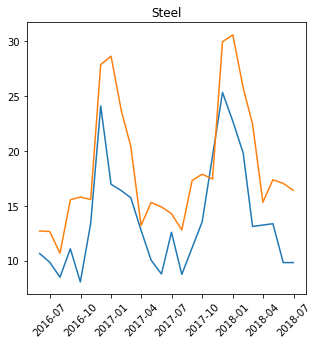

In [32]:
predictions = stepwise_model.predict(n_periods=test_size)
fig, ax = plt.subplots(1,1, figsize = (5,5))
ax.plot(dfw.price_steel_interpolated.index[train_size:], dfw.price_steel_interpolated[train_size:])
ax.plot(dfw.price_steel_interpolated.index[train_size:], predictions)
ax.set_title('Steel')
ax.tick_params(axis = 'x', rotation = 45)

# Forecasting with SARIMAX

In [55]:
def get_sarimax_model (X_train):
    model = auto_arima(X_train, start_p=1, start_q=1,
                    max_p=3, max_q=3, m=12,
                    start_P=0, seasonal=True,
                    d=1, D=1, trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)
    #print(model.aic())
    print('--------')
    print(model.fit(X_train))
    return model

In [56]:
def split_data (X):
    train = int(0.9 * X.shape[0])
    X_train = X[:train]
    X_test = X[train:]
    return X_train, X_test

In [57]:
def predictions(c, X_test, model_fit):
    yhat = model_fit.predict(n_periods = len(X_test))
    fig, ax = plt.subplots(1,1, figsize = (10,5))
    ax.plot(X_test.index, X_test)
    ax.plot(X_test.index, yhat)
    ax.set_title(c + ' predictions')
    ax.tick_params(axis = 'x', rotation = 45)
    plt.show()

In [58]:
def forecasts (c, X, n_future, model_fit):
    yhat = model_fit.predict(n_periods = 6)
    return yhat         
                

In [59]:
def forecasting (c, X):
    display(HTML('<h3><hr>' + c + '</hr>'))
    X = X.dropna()
    X_train, X_test = split_data(X)
    model = get_sarimax_model (X_train)
    model_fit = model.fit(X_train)
    predictions(c, X_test, model_fit)
    
    model = get_sarimax_model (X)
    model_fit = model.fit(X)
    yhat = forecasts (c, X, 6, model_fit)
    return yhat

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=571.947, BIC=585.169, Time=0.779 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=646.576, BIC=651.865, Time=0.010 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=609.389, BIC=619.966, Time=0.117 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=571.608, BIC=582.185, Time=0.263 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=644.577, BIC=647.222, Time=0.010 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=True]; AIC=599.599, BIC=607.532, Time=0.045 seconds
Fit ARIMA(0,1,1)x(1,1,1,12) [intercept=True]; AIC=573.351, BIC=586.573, Time=0.341 seconds
Fit ARIMA(0,1,1)x(0,1,2,12) [intercept=True]; AIC=573.316, BIC=586.537, Time=0.971 seconds
Fit ARIMA(0,1,1)x(1,1,0,12) [intercept=True]; AIC=582.451, BIC=593.029, Time=0.145 seconds
Fit ARIMA(0,1,1)x(1,1,2,12) [intercept=True]; AIC=575.283, BIC=591.150, Time=1.097 seconds
Fit ARIMA(0,1,0)x(0,1,1,12) [intercept=True]; 

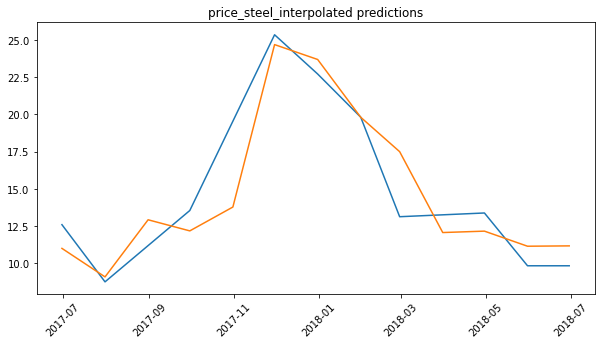

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=633.866, BIC=647.677, Time=0.665 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=720.065, BIC=725.589, Time=0.011 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=684.488, BIC=695.537, Time=0.156 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=634.069, BIC=645.117, Time=0.594 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=718.067, BIC=720.829, Time=0.014 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=667.761, BIC=678.810, Time=0.204 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=635.614, BIC=652.187, Time=1.051 seconds
N

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=565.856, BIC=579.078, Time=0.760 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=646.556, BIC=651.844, Time=0.116 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=622.422, BIC=633.000, Time=0.140 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=569.406, BIC=579.984, Time=0.447 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=644.556, BIC=647.200, Time=0.013 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=611.471, BIC=622.049, Time=0.255 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=567.852, BIC=583.719, Time=0.973 seconds
N

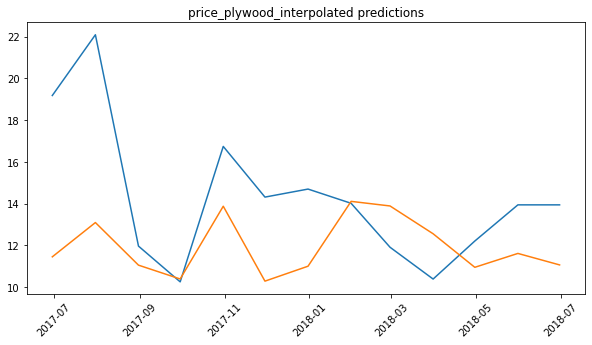

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=633.375, BIC=647.186, Time=0.847 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=723.437, BIC=728.961, Time=0.013 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=693.379, BIC=704.428, Time=0.175 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=641.400, BIC=652.448, Time=0.640 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=721.438, BIC=724.200, Time=0.017 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=684.399, BIC=695.448, Time=0.257 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=635.368, BIC=651.941, Time=1.211 seconds
N

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=676.512, BIC=689.538, Time=0.755 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=742.939, BIC=748.149, Time=0.013 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=719.508, BIC=729.928, Time=0.150 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=680.387, BIC=690.808, Time=0.519 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=740.945, BIC=743.550, Time=0.015 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=713.989, BIC=724.410, Time=0.214 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=678.384, BIC=694.015, Time=0.722 seconds
N

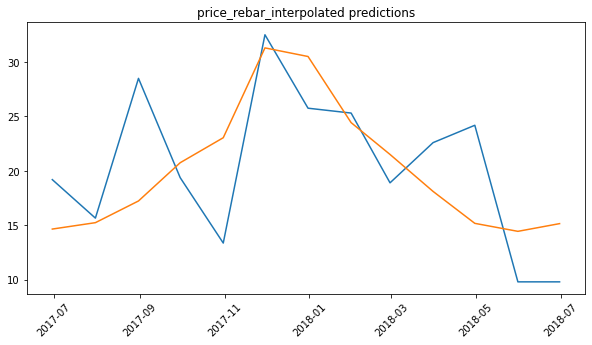

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=760.156, BIC=773.793, Time=0.718 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=843.863, BIC=849.318, Time=0.013 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=819.029, BIC=829.939, Time=0.189 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=763.422, BIC=774.331, Time=0.663 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=841.863, BIC=844.591, Time=0.014 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=808.108, BIC=819.018, Time=0.239 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=762.008, BIC=778.372, Time=0.798 seconds
N

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=548.927, BIC=562.149, Time=0.849 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=573.453, BIC=578.742, Time=0.029 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=564.125, BIC=574.702, Time=0.138 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=552.764, BIC=563.342, Time=0.166 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=571.454, BIC=574.099, Time=0.013 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=576.577, BIC=587.154, Time=0.069 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=553.833, BIC=569.699, Time=0.759 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(0,1,2,12) [intercept=True]; AIC=554.425, BIC=570.291, Time=0.925 seconds
Fit ARIMA(1,1,1)x(1,1,0,12) [intercept=True]; AIC=559.039, BIC=572.26

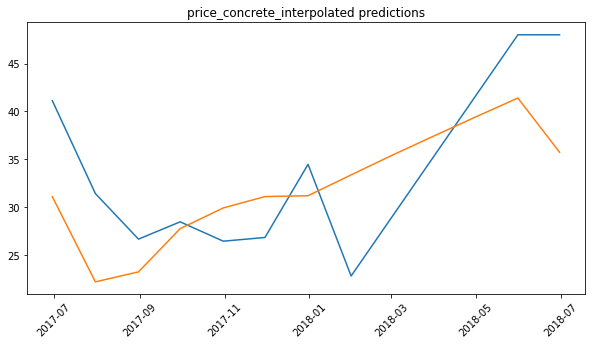

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=643.545, BIC=657.356, Time=0.871 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=677.883, BIC=683.407, Time=0.013 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=664.474, BIC=675.523, Time=0.160 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=650.155, BIC=661.204, Time=0.203 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=675.920, BIC=678.682, Time=0.013 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=671.558, BIC=682.607, Time=0.356 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=643.825, BIC=660.398, Time=1.059 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
F

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=515.106, BIC=528.328, Time=0.364 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=580.295, BIC=585.584, Time=0.013 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=537.365, BIC=547.942, Time=0.136 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=513.284, BIC=523.861, Time=0.232 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=578.305, BIC=580.949, Time=0.014 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=565.742, BIC=576.320, Time=0.073 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=515.624, BIC=531.491, Time=0.322 seconds
Fit ARIMA(1,1,1)x(0,1,2,12) [intercept=True]; AIC=514.675, BIC=530.541, Time=0.965 seconds
Fit ARIMA(1,1,1)x(1,1,2,12) [intercept=True]; AIC=518.706, BIC=537.21

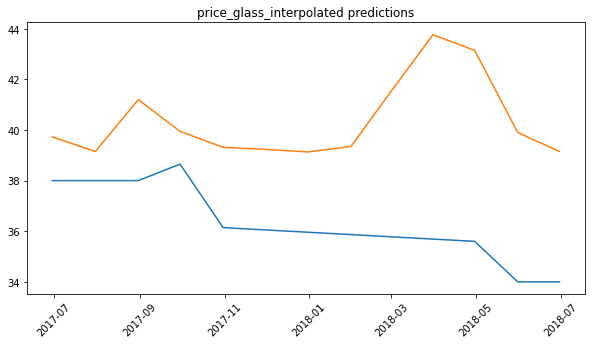

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=568.486, BIC=582.297, Time=0.363 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=640.879, BIC=646.403, Time=0.103 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=598.796, BIC=609.844, Time=0.159 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=566.567, BIC=577.616, Time=0.240 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=638.895, BIC=641.658, Time=0.015 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=625.997, BIC=637.046, Time=0.060 seconds
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=569.362, BIC=585.935, Time=0.417 seconds
Fit ARIMA(1,1,1)x(0,1,2,12) [intercept=True]; AIC=568.602, BIC=585.175, Time=0.725 seconds
Fit ARIMA(1,1,1)x(1,1,0,12) [intercept=True]; AIC=596.658, BIC=610.46

In [60]:
dfo = pd.DataFrame(columns = ds_cols)
dfo['month'] = ['2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31']

for c in ds_cols:
    X = dfw[c]
    dfo[c] = forecasting (c, X)

# Save Final 6-Month Forecast

In [61]:
dfo.to_csv('data/construction_forecast.csv', index = False)
dfo

,price_steel_interpolated,price_plywood_interpolated,price_rebar_interpolated,price_concrete_interpolated,price_glass_interpolated,month
0,9.237355,15.051687,15.237896,37.086443,34.926585,2018-07-31
1,12.988838,12.024072,19.373775,34.236020,37.387673,2018-08-31
2,12.982009,11.276000,21.638790,36.461596,37.458806,2018-09-30
3,16.226631,15.062396,23.120512,36.009639,37.130170,2018-10-31
4,25.335775,11.606134,32.482120,37.419724,37.702288,2018-11-30
5,23.862303,12.319191,31.107044,39.123458,38.131123,2018-12-31
